<h1>ECE521 Assignment 1</h1>

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<h2>Utils</h2>

In [11]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.
     
     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(input_tensor, 
                                    reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, 
                                       reduction_indices) 
  return tf.log(tf.reduce_sum(tf.exp(input_tensor - max_input_tensor2), 
                                reduction_indices, keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     
 
  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, keep_dims=True)

<h2>1</h2>

<h3>1.1.2</h3>

In [51]:
data = np.load("../data/data2D.npy")
points_2d = data
print(data)

[[ 1.69424762 -2.4385797 ]
 [ 1.12750805 -2.06013747]
 [ 2.40075462 -2.96636567]
 ..., 
 [-1.11873012 -3.41074163]
 [ 1.58777283  0.14010238]
 [ 1.36922966  0.26141621]]


In [73]:
def buildGraph_K_means_Adam(N, K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    centroids = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='centroids')

    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), 
                            reduction_indices=2)
    best_centroids = tf.argmin(sum_squares, 1)
    count = tf.to_float(tf.unsorted_segment_sum(tf.ones_like(points), best_centroids, K))
    percentage = count / N
    # Loss definition
    loss = tf.reduce_sum(tf.gather(sum_squares, best_centroids))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, centroids, best_centroids, loss, percentage, train

In [39]:
Number_of_data = points_2d.shape[0]
# fix figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


Centers: 0.15, 0.30
Centers: 1.56, -2.35
Centers: 1.50, -2.35
Centers: 1.64, -2.41
Centers: 1.56, -2.34


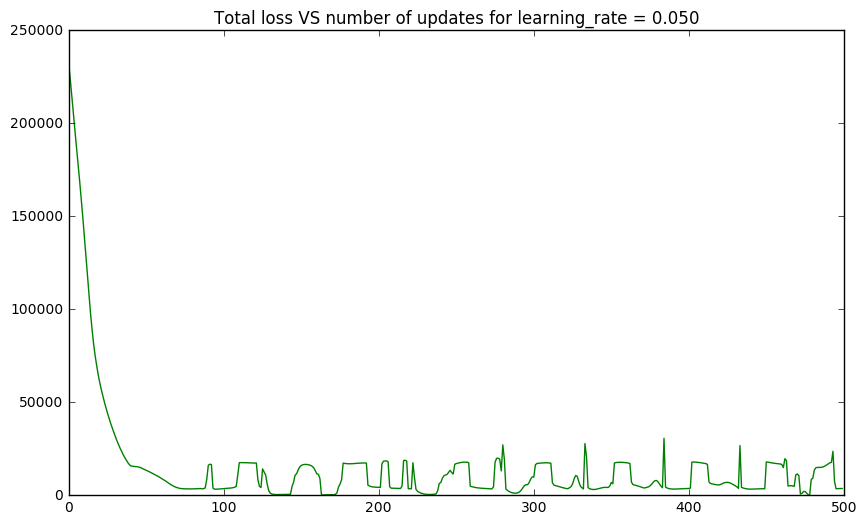

In [57]:
learning_rate = 0.05
points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(Number_of_data, 3, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 500
for itr in range(numIteration):
    loss_, center, _ = sess.run([loss, centroids[0], train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Centers: %0.2f, %0.2f"%(center[0], center[1]))
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<h3>1.1.3</h3>

Percentage for different clusters:
Total K is 1, cluster 0: 1.00


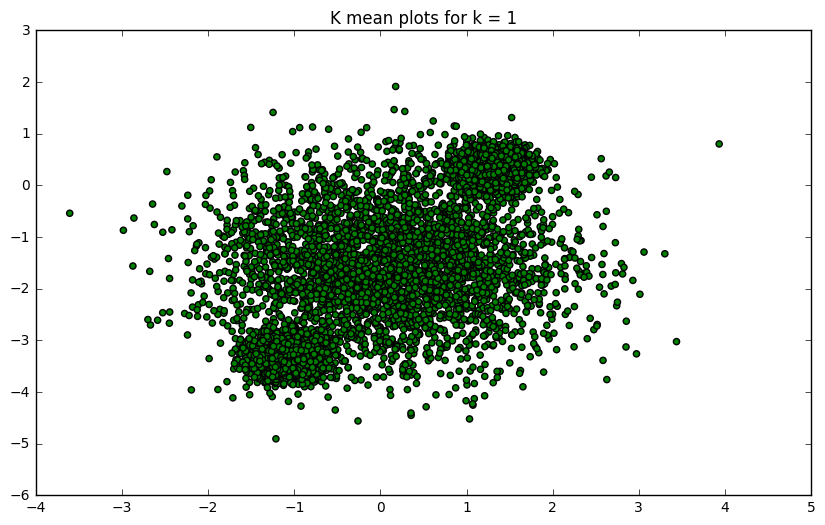

Percentage for different clusters:
Total K is 2, cluster 0: 0.08
Total K is 2, cluster 1: 0.92


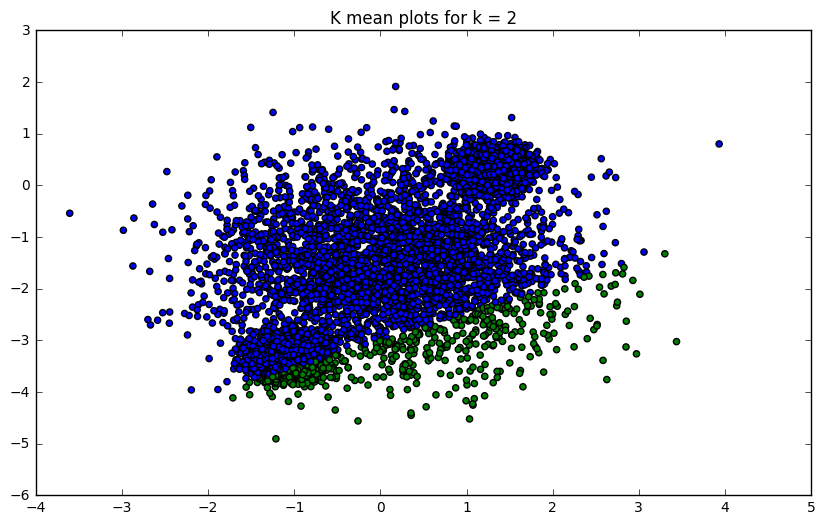

Percentage for different clusters:
Total K is 3, cluster 0: 0.41
Total K is 3, cluster 1: 0.00
Total K is 3, cluster 2: 0.59


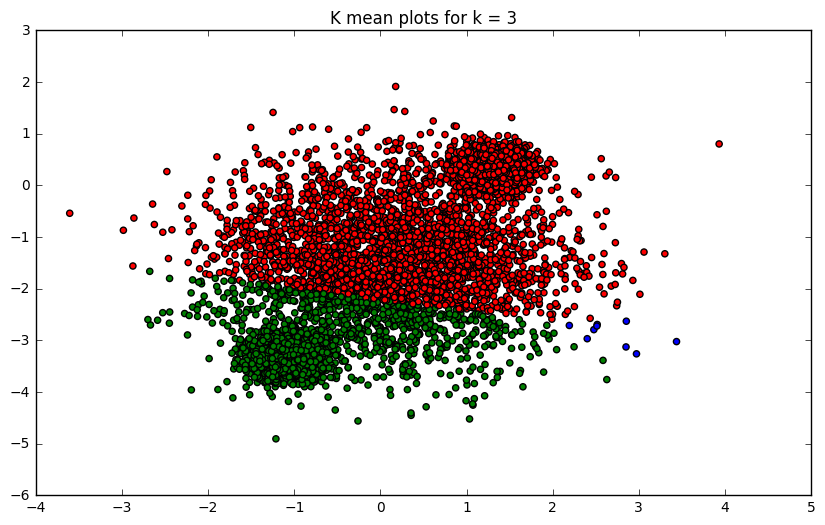

Percentage for different clusters:
Total K is 4, cluster 0: 0.00
Total K is 4, cluster 1: 0.00
Total K is 4, cluster 2: 0.62
Total K is 4, cluster 3: 0.38


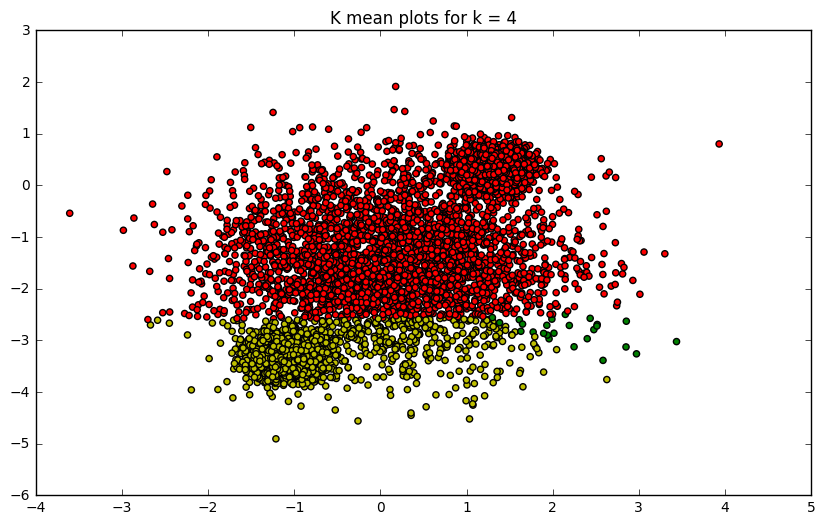

Percentage for different clusters:
Total K is 5, cluster 0: 0.00
Total K is 5, cluster 1: 0.00
Total K is 5, cluster 2: 0.25
Total K is 5, cluster 3: 0.64
Total K is 5, cluster 4: 0.11


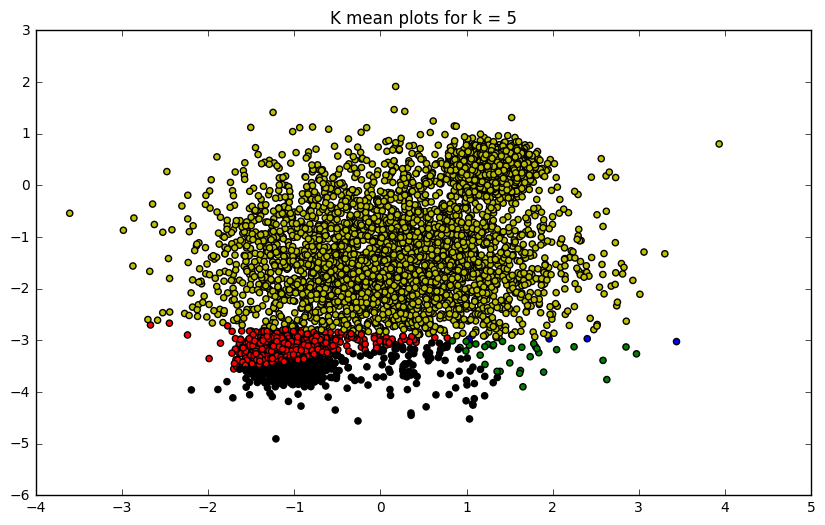

In [88]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.05
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(Number_of_data, K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])

    numIteration = 500
    P = []
    assign = []
    for itr in range(numIteration):
        loss_, P, assign, _ = sess.run([loss, percentage, centroids_assign, train], feed_dict={points: points_2d})
        loss_recorder = np.append(loss_recorder, loss_)
    print("Percentage for different clusters:")
    for k in range(K):
        print("Total K is %d, cluster %d: %0.2f"%(K, k, P[k][0])) 
    x = points_2d[:,0]
    y = points_2d[:,1]
    colors = [color_list[assign[x]] for x in range(Number_of_data)]
    plt.scatter(x,y,c=colors)
    #plt.axis([0,500, 0, 2])
    plt.title("K mean plots for k = %d"%(K))
    plt.show()

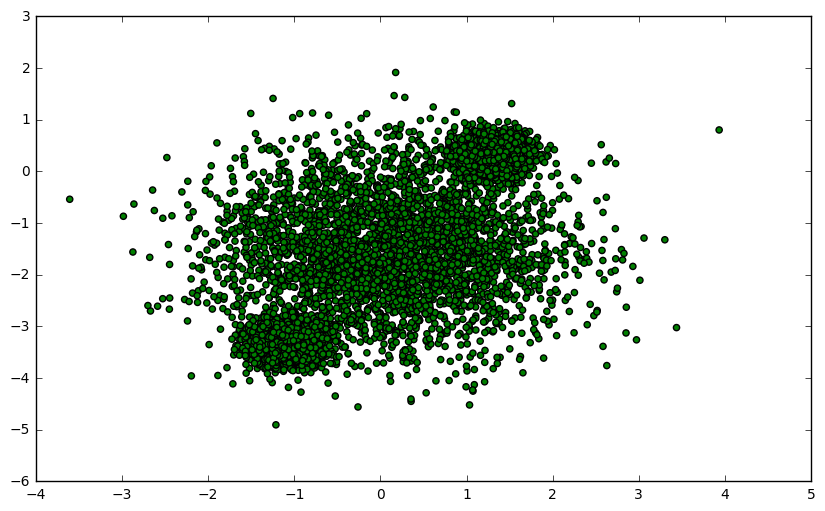

In [85]:
x = points_2d[:,0]
y = points_2d[:,1]
colors = ["g" for x in points_2d[:,0]]
plt.scatter(x,y,c=colors)

<h3>1.1.4</h3>